In [1]:
# import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import set_config; set_config(display='diagram')
from pycaret.regression import setup, compare_models

# sklearn preproc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectPercentile, mutual_info_regression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor, ExtraTreesRegressor, RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import BayesianRidge, Ridge
from keras import Sequential, layers

# Predicting House Sale Prices, Advanced Regression Techniques - Kaggle

In [2]:
# Load Kaggle train dataset
train = pd.read_csv("data/train.csv")
data = train.drop(columns=['Id'])
# Load Kaggke test dataset
test = pd.read_csv("data/test.csv")
test_id = test.Id
test = test.drop(columns=['Id'])

print(f'The size of the train dataset is : {train.shape}')
print(f'The size of the test dataset is : {test.shape}')

The size of the train dataset is : (1460, 81)
The size of the test dataset is : (1459, 79)


In [3]:
# Set X and y
y = data.SalePrice
X = data.drop(columns=['SalePrice'])
X.shape, y.shape

((1460, 79), (1460,))

# Contents

- Exploratory Data Analysis (EDA)
- Data Cleaning (Duplicate, Outliers, and Missing Value)
- Feature Engineering
- Feature Transformations
- Feature Selection
- Preprocessor pipeline (Encoding & Scaling)
- Target Transformation
- Model Selection
- Model Evaluation
- Hyperparameter Optimization
- Ensembling Models
- Neural Network

# Exploratory Data Analysis (EDA)

In [4]:
data.head(5)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
# Investigate the Data using .info()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

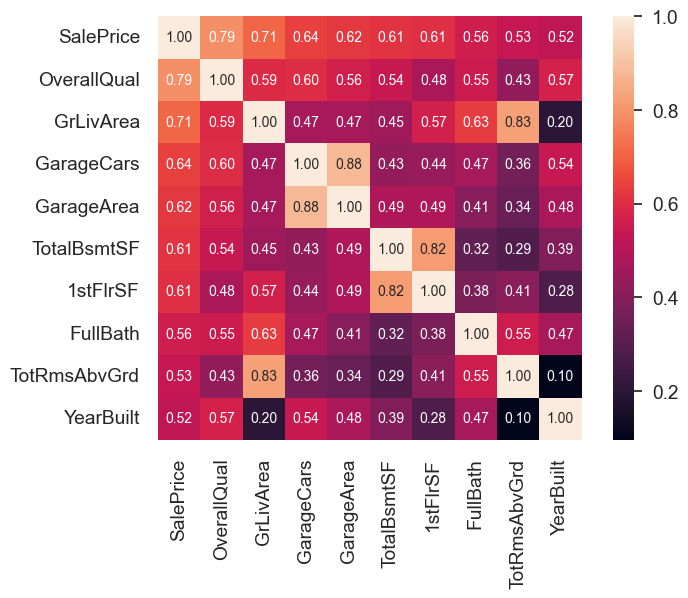

In [6]:
# Investigate the saleprice correlation matrix
k = 10 #number of variables for heatmap
corr_matrix = data.select_dtypes(include=np.number).corr()
cols = corr_matrix.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(data[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

# Data Cleaning

## Duplicate

In [7]:
# Drop duplicates- No duplicated row
X.duplicated().sum()

0

## Outliers

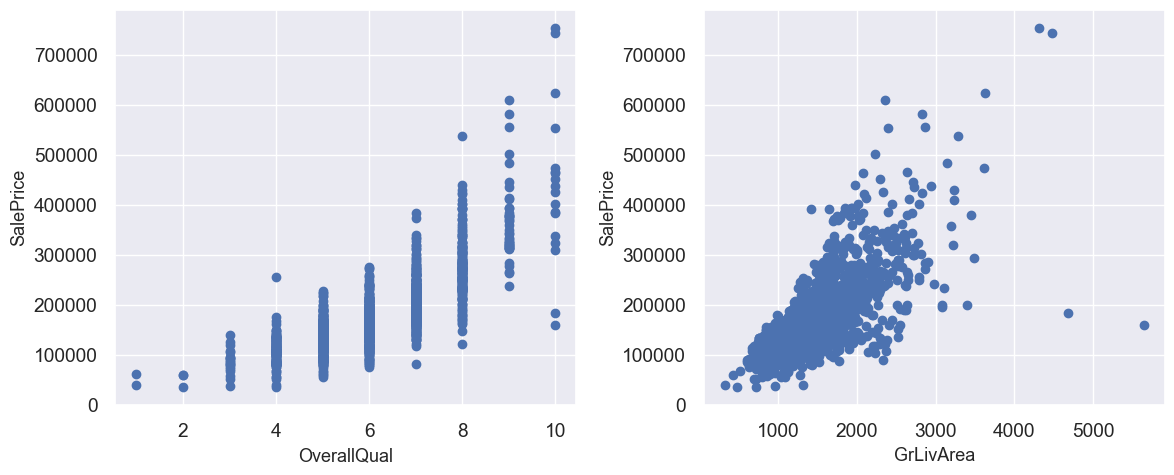

In [8]:
# Investigate outliers of features that have high relationship with Saleprice
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.scatter(x=data['OverallQual'], y=data['SalePrice'])
ax1.set_ylabel('SalePrice', fontsize=13)
ax1.set_xlabel('OverallQual', fontsize=13)

ax2.scatter(x=data['GrLivArea'], y=data['SalePrice'])
ax2.set_ylabel('SalePrice', fontsize=13)
ax2.set_xlabel('GrLivArea', fontsize=13)

fig.tight_layout()

plt.show()

In [9]:
# Deleting outliers
data = data.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index)

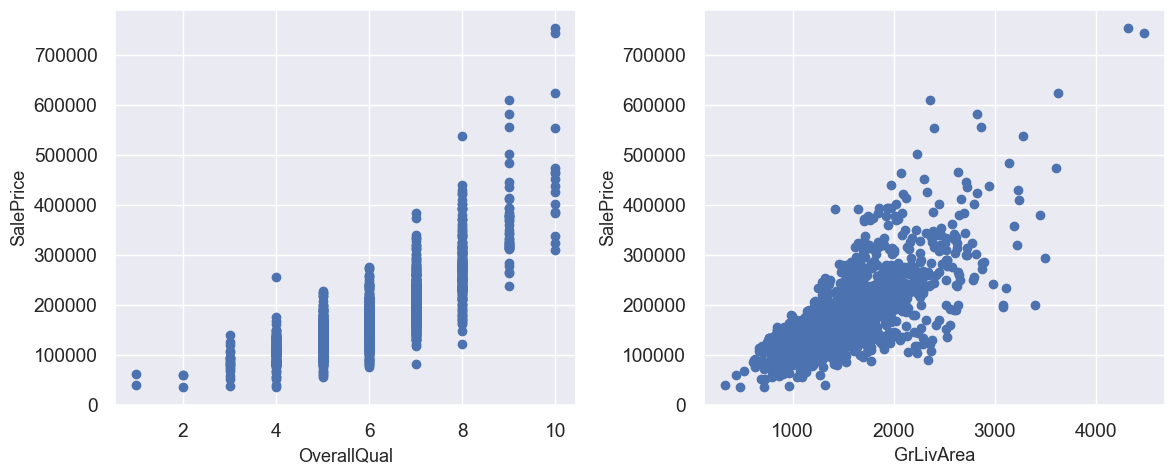

In [10]:
# Graph after deleting the outliers
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.scatter(x=data['OverallQual'], y=data['SalePrice'])
ax1.set_ylabel('SalePrice', fontsize=13)
ax1.set_xlabel('OverallQual', fontsize=13)

ax2.scatter(x=data['GrLivArea'], y=data['SalePrice'])
ax2.set_ylabel('SalePrice', fontsize=13)
ax2.set_xlabel('GrLivArea', fontsize=13)

fig.tight_layout()

plt.show()

# Missing value

In [11]:
# Investigate the missing value
No_of_null = X.isna().sum().sort_values(ascending = False)
Percentage = X.isna().sum().sort_values(ascending = False)/X.shape[0]
Missing = pd.concat([No_of_null, Percentage], axis=1, keys=['Number', 'Percentage'])
Missing.head(10)

,Number,Percentage
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageType,81,0.055479
GarageYrBlt,81,0.055479
GarageQual,81,0.055479
GarageCond,81,0.055479


In the document data description, it mentioned null values do have meaning in different columns. E.g. PoolQC, null valeus represent "No Pool".

In [12]:
# Ensure Proper Data Types

#MSSubClass=The building class
X['MSSubClass'] = X['MSSubClass'].apply(str)

#Year and month sold are transformed into categorical features.
X['YrSold'] = X['YrSold'].astype(str)
X['MoSold'] = X['MoSold'].astype(str)

# Feature Engineering

This function will be added later in the preprocessor pipline

In [13]:
def add_features(X):
    # Add four more features
    X["SqFtPerRoom"] = X["GrLivArea"] / (X["TotRmsAbvGrd"] +
                                        X["FullBath"] +
                                        X["HalfBath"] +
                                        X["KitchenAbvGr"])

    X['Total_Home_Quality'] = X['OverallQual'] + X['OverallCond']

    X['Total_Bathrooms'] = (X['FullBath'] + (0.5 * X['HalfBath']) +
                            X['BsmtFullBath'] + (0.5 * X['BsmtHalfBath']))

    X["HighQualSF"] = X["1stFlrSF"] + X["2ndFlrSF"]

    # Ensure Proper Data Types
    X['MSSubClass'] = X['MSSubClass'].astype(str)
    X['YrSold'] = X['YrSold'].astype(str)
    X['MoSold'] = X['MoSold'].astype(str)

    return X

# Feature Transformations

In [14]:
# Define numerical features
feat_numerical = X.select_dtypes(include=["int64", "float64"]).columns

# Define ordinal features
feat_ordinal_dict = {
    # considers "missing" as "neutral"
    "BsmtCond": ['missing', 'Po', 'Fa', 'TA', 'Gd'],
    "BsmtExposure": ['missing', 'No', 'Mn', 'Av', 'Gd'],
    "BsmtFinType1": ['missing', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],
    "BsmtFinType2": ['missing', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],
    "BsmtQual": ['missing', 'Fa', 'TA', 'Gd', 'Ex'],
    "Electrical": ['missing', 'Mix', 'FuseP', 'FuseF', 'FuseA', 'SBrkr'],
    "ExterCond": ['missing', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    "ExterQual": ['missing', 'Fa', 'TA', 'Gd', 'Ex'],
    "FireplaceQu": ['missing', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    "Functional": ['missing', 'Sev', 'Maj2', 'Maj1', 'Mod', 'Min2', 'Min1', 'Typ'],
    "GarageCond": ['missing', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    "GarageFinish": ['missing', 'Unf', 'RFn', 'Fin'],
    "GarageQual": ['missing', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    "HeatingQC": ['missing', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    "KitchenQual": ['missing', 'Fa', 'TA', 'Gd', 'Ex'],
    "LandContour": ['missing', 'Low', 'Bnk', 'HLS', 'Lvl'],
    "LandSlope": ['missing', 'Sev', 'Mod', 'Gtl'],
    "LotShape": ['missing', 'IR3', 'IR2', 'IR1', 'Reg'],
    "PavedDrive": ['missing', 'N', 'P', 'Y'],
}
feat_ordinal = sorted(feat_ordinal_dict.keys()) # sort alphabetically
feat_ordinal_values_sorted = [feat_ordinal_dict[i] for i in feat_ordinal]

# Define nominal features as the remaining ones (non numerical, non ordinal)
feat_nominal = sorted(list(set(X.columns) - set(feat_numerical) - set(feat_ordinal)))


Numerical Features:
- KNNImputer (filling the null values by mean)
- MinMaxScaler (Normalization, Scaling to range 0 and 1 )

Ordinal Features:
- KNNImputer (filling the null values by constant str value "missing")
- encoder_ordinal (OrdinalEncoder == Label Encoder)
- MinMaxScaler (Normalization, Scaling to range 0 and 1 )

Nomainal Features:
- SimpleImputer (filling the null values by mode)
- OneHotEncoder

In [15]:
# Define the preprocessor pipeline for numerical, ordinal, nomainal features
encoder_ordinal = OrdinalEncoder(
        categories=feat_ordinal_values_sorted,
        dtype= np.int64,
        handle_unknown="use_encoded_value",
        unknown_value=-1 # Considers unknown values as worse than "missing"
    )

preproc_ordinal = make_pipeline(
        SimpleImputer(strategy="constant", fill_value="missing"),
        encoder_ordinal,
        MinMaxScaler()
    )

preproc_numerical = make_pipeline(
        KNNImputer(),
        MinMaxScaler()
    )

preproc_nominal = make_pipeline(
        SimpleImputer(strategy="most_frequent"),
        OneHotEncoder(handle_unknown="ignore")
    )

preproc_transformer = make_column_transformer(
        (preproc_numerical, feat_numerical),
        (preproc_ordinal, feat_ordinal),
        (preproc_nominal, feat_nominal),
        remainder="drop")

preprocessor = make_pipeline(preproc_transformer)
preprocessor

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('knnimputer',
                                                                   KNNImputer()),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  Index(['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', '...
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Alley', 'BldgType',
                                                   'CentralAir', 'Condition1',
                                                   'Condition2', 'Exterior1st',
                                                   'Exterior2nd', 'Fence',
                                                   'Foundation', 'GarageType',
                                                   'Heating', 'HouseStyle',
                                                   'LotConfig', 'MSSubClass',
                                                   'MSZoning', 'MasVnrType',
                                                   'MiscFeature', 'MoSold',
                                                   'Neighborhood', 'PoolQC',
                                                   'RoofMatl', 'RoofStyle',
                                                   'SaleCondition', 'SaleType',
                                                   'Street', 'Utilities',
                                                   'YrSold'])]))])

# Feature Selection

In [16]:
# Select the top features based on a scoring function
preproc_selector = SelectPercentile(
        mutual_info_regression,
        percentile=75, # keep only 75% of all features )
    )

# Preprocessor pipeline

In [17]:
def preprocessor(X):
    # Add features
    X = add_features(X)

    # Define ordinal features
    feat_ordinal_dict = {
        # considers "missing" as "neutral"
        "BsmtCond": ['missing', 'Po', 'Fa', 'TA', 'Gd'],
        "BsmtExposure": ['missing', 'No', 'Mn', 'Av', 'Gd'],
        "BsmtFinType1": ['missing', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],
        "BsmtFinType2": ['missing', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],
        "BsmtQual": ['missing', 'Fa', 'TA', 'Gd', 'Ex'],
        "Electrical": ['missing', 'Mix', 'FuseP', 'FuseF', 'FuseA', 'SBrkr'],
        "ExterCond": ['missing', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
        "ExterQual": ['missing', 'Fa', 'TA', 'Gd', 'Ex'],
        "Fence": ['missing', 'MnWw', 'GdWo', 'MnPrv', 'GdPrv'],
        "FireplaceQu": ['missing', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
        "Functional": ['missing', 'Sev', 'Maj2', 'Maj1', 'Mod', 'Min2', 'Min1', 'Typ'],
        "GarageCond": ['missing', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
        "GarageFinish": ['missing', 'Unf', 'RFn', 'Fin'],
        "GarageQual": ['missing', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
        "HeatingQC": ['missing', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
        "KitchenQual": ['missing', 'Fa', 'TA', 'Gd', 'Ex'],
        "LandContour": ['missing', 'Low', 'Bnk', 'HLS', 'Lvl'],
        "LandSlope": ['missing', 'Sev', 'Mod', 'Gtl'],
        "LotShape": ['missing', 'IR3', 'IR2', 'IR1', 'Reg'],
        "PavedDrive": ['missing', 'N', 'P', 'Y'],
        "PoolQC": ['missing', 'Fa', 'Gd', 'Ex'],
    }

    feat_ordinal = sorted(feat_ordinal_dict.keys()) # sort alphabetically
    feat_ordinal_values_sorted = [feat_ordinal_dict[i] for i in feat_ordinal]

    # Define feat_numerical features
    feat_numerical = X.select_dtypes(include=["int64", "float64"]).columns

    # Define ordinal features
    feat_nominal = sorted(list(set(X.columns) - set(feat_numerical) - set(feat_ordinal)))


    encoder_ordinal = OrdinalEncoder(
        categories=feat_ordinal_values_sorted,
        dtype= np.int64,
        handle_unknown="use_encoded_value",
        unknown_value=-1 # Considers unknown values as worse than "missing"
    )

    preproc_ordinal = make_pipeline(
        SimpleImputer(strategy="constant", fill_value="missing"),
        encoder_ordinal,
        MinMaxScaler()
    )

    preproc_numerical = make_pipeline(
        KNNImputer(),
        MinMaxScaler()
    )

    preproc_nominal = make_pipeline(
        SimpleImputer(strategy="most_frequent"),
        OneHotEncoder(handle_unknown="ignore")
    )

    preproc_transformer = make_column_transformer(
        (preproc_numerical, feat_numerical),
        (preproc_ordinal, feat_ordinal),
        (preproc_nominal, feat_nominal),
        remainder="drop")

    preproc_selector = SelectPercentile(
        mutual_info_regression,
        percentile=75, # keep only xx% of all features )
    )
    preprocessor = make_pipeline(
        preproc_transformer,
        preproc_selector
    )
    return preprocessor

preprocessor = preprocessor(X)
preprocessor

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('knnimputer',
                                                                   KNNImputer()),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  Index(['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', '...
                                                   'Exterior2nd', 'Foundation',
                                                   'GarageType', 'Heating',
                                                   'HouseStyle', 'LotConfig',
                                                   'MSSubClass', 'MSZoning',
                                                   'MasVnrType', 'MiscFeature',
                                                   'MoSold', 'Neighborhood',
                                                   'RoofMatl', 'RoofStyle',
                                                   'SaleCondition', 'SaleType',
                                                   'Street', 'Utilities',
                                                   'YrSold'])])),
                ('selectpercentile',
                 SelectPercentile(percentile=75,
                                  score_func=<function mutual_info_regression at 0x000001D4DE6ED090>))])

# Target Transformation 

In [18]:
# Descriptive statistics
y.describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

<Axes: xlabel='SalePrice', ylabel='Density'>

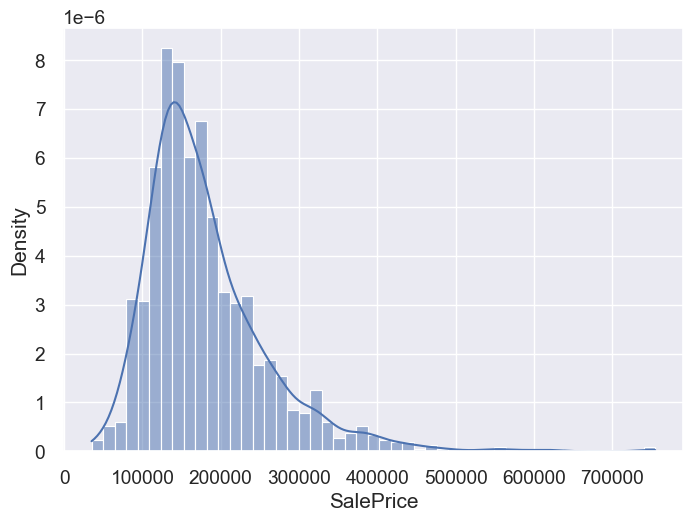

In [19]:
# Density distribution plots
sns.histplot(y, kde=True, stat="density")

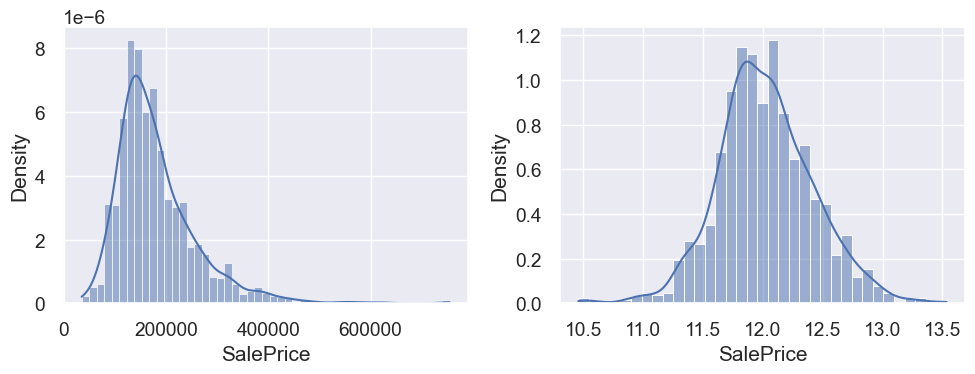

In [20]:
# Target "SalePrice" after Log-transformed
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
sns.histplot(y, kde=True, stat="density")

plt.subplot(1,2,2)
sns.histplot(np.log1p(y), kde=True, stat="density")

plt.tight_layout()

In [21]:
# logarithmic transformation
y = np.log1p(y)
y.describe()

count    1460.000000
mean       12.024057
std         0.399449
min        10.460271
25%        11.775105
50%        12.001512
75%        12.273736
max        13.534474
Name: SalePrice, dtype: float64

# Model Selection

In [22]:
# Set up the pycaret
preproc_X = preprocessor.fit_transform(X,y)
_ = setup(data=pd.concat([pd.DataFrame(preproc_X), y], axis=1), target='SalePrice')

,Description,Value
0,Session id,7474
1,Target,SalePrice
2,Target type,Regression
3,Original data shape,"(1460, 187)"
4,Transformed data shape,"(1460, 187)"
5,Transformed train set shape,"(1021, 187)"
6,Transformed test set shape,"(439, 187)"
7,Numeric features,186
8,Preprocess,True
9,Imputation type,simple


In [23]:
# Find multiple regression models based on their performance
models = compare_models(sort='rmse', n_select=6, verbose=True)
models

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,18:29:27
Status,. . . . . . . . . . . . . . . . . .,Loading Dependencies
Estimator,. . . . . . . . . . . . . . . . . .,Compiling Library


[GradientBoostingRegressor(random_state=7474),
 LGBMRegressor(random_state=7474),
 BayesianRidge(),
 Ridge(random_state=7474),
 ExtraTreesRegressor(n_jobs=-1, random_state=7474),
 RandomForestRegressor(n_jobs=-1, random_state=7474)]

# Model Evaluation

In [24]:
# Train/Val Split
X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.3)

# Apply these transformations to both the training set and the validation set.
preproc_Xtrain = preprocessor.fit_transform(X_train,y_train)
preproc_Xvalidation = preprocessor.transform(X_validation)

print(f"X train and X validation dataset size: {X_train.shape}, {X_validation.shape}")
print(f"preproc X train and X validation dataset size: {preproc_Xtrain.shape}, {preproc_Xvalidation.shape}")

X train and X validation dataset size: (1022, 83), (438, 83)
preproc X train and X validation dataset size: (1022, 184), (438, 184)


In [25]:
# Define the scoring
rmse = make_scorer(lambda y_true, y_pred: mean_squared_error(y_true, y_pred)**0.5)
rmse_neg = make_scorer(lambda y_true, y_pred: -1 * mean_squared_error(y_true, y_pred)**0.5)

In [26]:
# Loop through the list of models and calculate cross-validated RMSE
for model in models:
    scores = cross_val_score(model, preproc_Xtrain, y_train, cv=5, scoring=rmse)
    rmse_mean = scores.mean()
    print(f"Model: {model.__class__.__name__}, RMSE: {rmse_mean}")

Model: GradientBoostingRegressor, RMSE: 0.12568749922943462
Model: LGBMRegressor, RMSE: 0.135947316566226
Model: BayesianRidge, RMSE: 0.13445975828648757
Model: Ridge, RMSE: 0.13604059169421828
Model: ExtraTreesRegressor, RMSE: 0.13678590046784134
Model: RandomForestRegressor, RMSE: 0.14463339328873648


In [27]:
# Loop through the list of models and calculate RMSE on the validation set
for model in models:
    model.fit(preproc_Xtrain, y_train)  # Train the model on the training set
    y_pred = model.predict(preproc_Xvalidation)  # Make predictions on the validation set
    rmse = np.sqrt(mean_squared_error(y_validation, y_pred))  # Calculate RMSE
    print(f"Model: {model.__class__.__name__}, RMSE: {rmse}")

Model: GradientBoostingRegressor, RMSE: 0.12972291299828514
Model: LGBMRegressor, RMSE: 0.1339710414489818
Model: BayesianRidge, RMSE: 0.13015012765230424
Model: Ridge, RMSE: 0.12997819154292756
Model: ExtraTreesRegressor, RMSE: 0.13717300134740984
Model: RandomForestRegressor, RMSE: 0.14186959347539294


# Hyperparameter optimization

In [28]:
# Define the models
models = [
    ("GradientBoostingRegressor", GradientBoostingRegressor()),
    ("LGBMRegressor", LGBMRegressor()),
    ("BayesianRidge", BayesianRidge()),
    ("Ridge", Ridge()),
    ("ExtraTreesRegressor", ExtraTreesRegressor()),
    ("RandomForestRegressor", RandomForestRegressor())
]

# Define the parameter grids for each model
param_grids = {
    "GradientBoostingRegressor": {
        "learning_rate": [0.1, 0.01, 0.001],
        "n_estimators": [100, 200, 300],
        "max_depth": [3, 4, 5]
    },
    "LGBMRegressor": {
        "learning_rate": [0.1, 0.01, 0.001],
        "n_estimators": [100, 200, 300],
        "num_leaves": [31, 40, 50]
    },
    "BayesianRidge": {
        "alpha_1": [1e-6, 1e-7, 1e-8],
        "alpha_2": [1e-6, 1e-7, 1e-8],
        "lambda_1": [1e-6, 1e-7, 1e-8],
        "lambda_2": [1e-6, 1e-7, 1e-8]
    },
    "Ridge": {
        "alpha": [0.1, 0.01, 0.001]
    },
    "ExtraTreesRegressor": {
        "n_estimators": [100, 200, 300],
        "max_depth": [None, 5, 10]
    },
    "RandomForestRegressor": {
        "n_estimators": [100, 200, 300],
        "max_depth": [None, 5, 10]
    }
}

# Define the scoring function
rmse = make_scorer(lambda y_true, y_pred: sqrt(mean_squared_error(y_true, y_pred)))

# Perform hyperparameter tuning for each model
best_models = {}

for name, model in models:
    param_grid = param_grids[name]
    grid_search = GridSearchCV(model, param_grid=param_grid, scoring=rmse_neg, cv=5)
    grid_search.fit(preproc_Xtrain, y_train)
    best_model = grid_search.best_estimator_
    best_models[name] = best_model
    print("Model: {}, Best Params: {}".format(name, grid_search.best_params_))
    print("Model: {}, Best Score: {}".format(name, -grid_search.best_score_))

Model: GradientBoostingRegressor, Best Params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300}
Model: GradientBoostingRegressor, Best Score: 0.12264756192857444
Model: LGBMRegressor, Best Params: {'learning_rate': 0.1, 'n_estimators': 100, 'num_leaves': 31}
Model: LGBMRegressor, Best Score: 0.135947316566226
Model: BayesianRidge, Best Params: {'alpha_1': 1e-08, 'alpha_2': 1e-06, 'lambda_1': 1e-06, 'lambda_2': 1e-08}
Model: BayesianRidge, Best Score: 0.134459748499025
Model: Ridge, Best Params: {'alpha': 0.1}
Model: Ridge, Best Score: 0.14429389331056147
Model: ExtraTreesRegressor, Best Params: {'max_depth': None, 'n_estimators': 300}
Model: ExtraTreesRegressor, Best Score: 0.13452583150284927
Model: RandomForestRegressor, Best Params: {'max_depth': None, 'n_estimators': 100}
Model: RandomForestRegressor, Best Score: 0.14254825716243788


# Ensembling Models

In [29]:
gr_params = {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300}
lgbm_params = {'learning_rate': 0.1, 'n_estimators': 100, 'num_leaves': 31}
br_params = {'alpha_1': 1e-08, 'alpha_2': 1e-06, 'lambda_1': 1e-06, 'lambda_2': 1e-08}
r_params = {'alpha': 0.1}
et_params = {'max_depth': None, 'n_estimators': 300}
rt_params = {'max_depth': None, 'n_estimators': 200}

# Define the models
models = [
    ("GradientBoostingRegressor", GradientBoostingRegressor(**gr_params)),
    ("LGBMRegressor", LGBMRegressor(**lgbm_params)),
    ("BayesianRidge", BayesianRidge(**br_params)),
    ("Ridge", Ridge()),
    ("ExtraTreesRegressor", ExtraTreesRegressor(**et_params)),
    ("RandomForestRegressor", RandomForestRegressor(**rt_params))
]

# Train the models
trained_models = {}

for name, model in models:
    model.fit(preproc_Xtrain, y_train)
    trained_models[name] = model
    print(f"Model: {name}, RMSE: {np.sqrt(mean_squared_error(y_validation, model.predict(preproc_Xvalidation)))}")

Model: GradientBoostingRegressor, RMSE: 0.12582766639787804
Model: LGBMRegressor, RMSE: 0.1339710414489818
Model: BayesianRidge, RMSE: 0.1301501294555217
Model: Ridge, RMSE: 0.12997819154292756
Model: ExtraTreesRegressor, RMSE: 0.13677751537911384
Model: RandomForestRegressor, RMSE: 0.14225685326069706


In [30]:
# Preprocess the test dataset
preproc_Xtest = add_features(test)
preproc_Xtest = preprocessor.transform(test)

# Ensemble the models for predictions
final_predictions = (
    0.2 * np.exp(trained_models['GradientBoostingRegressor'].predict(preproc_Xtest)) +
    0.1 * np.exp(trained_models['LGBMRegressor'].predict(preproc_Xtest)) +
    0.4 * np.exp(trained_models['BayesianRidge'].predict(preproc_Xtest)) +
    0.1 * np.exp(trained_models['Ridge'].predict(preproc_Xtest)) +
    0.1 * np.exp(trained_models['ExtraTreesRegressor'].predict(preproc_Xtest)) +
    0.1 * np.exp(trained_models['RandomForestRegressor'].predict(preproc_Xtest))
)

# Submission
Ensemble_submission = pd.DataFrame(test_id,columns=['Id'])
Ensemble_submission['SalePrice'] = pd.DataFrame(final_predictions)
Ensemble_submission.to_csv(r'submission/Ensemble_submission.csv', index=False, header=True)
Ensemble_submission

# Kaggle public score: 0.12591

,Id,SalePrice
0,1461,118641.355061
1,1462,154993.345534
2,1463,170878.513928
3,1464,189362.567196
4,1465,188840.545233
...,...,...
1454,2915,85377.746159
1455,2916,80649.457127
1456,2917,153047.287666
1457,2918,112510.121088


### Export the Ensembling Models to a pickle file

In [31]:
import pickle

gr_params = {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300}
lgbm_params = {'learning_rate': 0.1, 'n_estimators': 100, 'num_leaves': 31}
br_params = {'alpha_1': 1e-08, 'alpha_2': 1e-06, 'lambda_1': 1e-06, 'lambda_2': 1e-08}
r_params = {'alpha': 0.1}
et_params = {'max_depth': None, 'n_estimators': 300}
rt_params = {'max_depth': None, 'n_estimators': 200}

# Define the models
models = [
    ("GradientBoostingRegressor", GradientBoostingRegressor(**gr_params)),
    ("LGBMRegressor", LGBMRegressor(**lgbm_params)),
    ("BayesianRidge", BayesianRidge(**br_params)),
    ("Ridge", Ridge()),
    ("ExtraTreesRegressor", ExtraTreesRegressor(**et_params)),
    ("RandomForestRegressor", RandomForestRegressor(**rt_params))
]

# Train the models
trained_models_full = {}

for name, model in models:
    model.fit(preproc_X, y)
    trained_models_full[name] = model

# Export the trained_models dictionary
with open('trained_models_full.pkl', 'wb') as file:
    pickle.dump(trained_models_full, file)

# Neural Network

## Feedforward Neural Network (FNN)

In [32]:
# Create a Feedforward Neural Network (FNN) neural network model
def initialize_model():
    model = Sequential()
    model.add(layers.Dense(64, activation='relu', input_dim=preproc_Xtrain.shape[1]))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))  # No activation function for the output layer in regression

    model.compile(loss='mean_squared_error', optimizer='adam')
    
    return model

NN_model = initialize_model()

In [33]:
# Train the model
history = NN_model.fit(preproc_Xtrain, y_train,validation_data = (preproc_Xvalidation, y_validation), batch_size=8, epochs=50)

Epoch 1/50
128/128 [==============================] - 1s 4ms/step - loss: 27.0738 - val_loss: 0.4239
Epoch 2/50
128/128 [==============================] - 0s 2ms/step - loss: 0.3358 - val_loss: 0.2273
Epoch 3/50
128/128 [==============================] - 0s 2ms/step - loss: 0.2011 - val_loss: 0.1912
Epoch 4/50
128/128 [==============================] - 0s 2ms/step - loss: 0.1399 - val_loss: 0.1272
Epoch 5/50
128/128 [==============================] - 0s 2ms/step - loss: 0.1039 - val_loss: 0.1350
Epoch 6/50
128/128 [==============================] - 0s 2ms/step - loss: 0.0907 - val_loss: 0.1044
Epoch 7/50
128/128 [==============================] - 0s 2ms/step - loss: 0.0746 - val_loss: 0.0985
Epoch 8/50
128/128 [==============================] - 0s 2ms/step - loss: 0.0667 - val_loss: 0.0877
Epoch 9/50
128/128 [==============================] - 0s 2ms/step - loss: 0.0551 - val_loss: 0.0819
Epoch 10/50
128/128 [==============================] - 0s 2ms/step - loss: 0.0462 - val_loss: 0.070

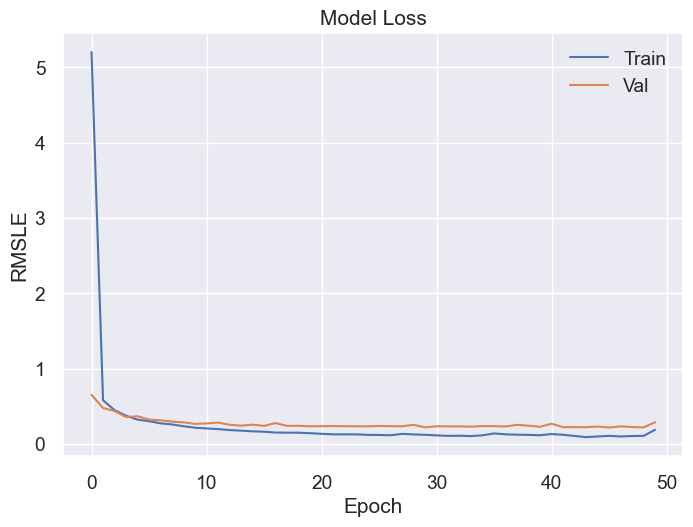

In [34]:
# Evaluate the NN model performance
def plot_history(history):
    plt.plot(np.sqrt(history.history['loss']))
    plt.plot(np.sqrt(history.history['val_loss']))
    plt.title('Model Loss')
    plt.ylabel('RMSLE')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='best')
    plt.show()

plot_history(history)

In [35]:
# Preprocess the test dataset
preproc_Xtest = add_features(test)
preproc_Xtest = preprocessor.transform(test)

# Use the model to predict test dataset
results_NN = NN_model.predict(preproc_Xtest)

# Submission
NN_submission = pd.DataFrame(test_id,columns=['Id'])
NN_submission['SalePrice'] = pd.DataFrame(np.exp(results_NN))
NN_submission.to_csv(r'submission/NN_submission.csv', index=False, header=True)
NN_submission

# Kaggle public score: 0.21667

46/46 [==============================] - 0s 1ms/step


,Id,SalePrice
0,1461,75594.664062
1,1462,101714.125000
2,1463,141737.156250
3,1464,156114.125000
4,1465,181675.031250
...,...,...
1454,2915,70087.476562
1455,2916,81940.945312
1456,2917,151526.453125
1457,2918,80085.085938


## Long Short-Term Memory (LSTM)

In [36]:
# Create a Long Short-Term Memory (LSTM) neural network model
def initialize_model():
    model = Sequential()
    model.add(layers.LSTM(128, return_sequences=True, input_shape=(preproc_Xtrain.shape[1], 1)))
    model.add(layers.Dropout(0.2))  # Apply dropout for regularization
    model.add(layers.LSTM(64, return_sequences=False))
    model.add(layers.Dense(25, activation='relu'))
    model.add(layers.Dense(1))

    model.compile(loss='mean_squared_error', optimizer='adam')

    return model

LSTM_model = initialize_model()

In [37]:
# Train the model
history1 = LSTM_model.fit(preproc_Xtrain, y_train,validation_data = (preproc_Xvalidation, y_validation), batch_size=8, epochs=50)

Epoch 1/50
128/128 [==============================] - 31s 207ms/step - loss: 12.1668 - val_loss: 0.1696
Epoch 2/50
128/128 [==============================] - 33s 256ms/step - loss: 0.1599 - val_loss: 0.1677
Epoch 3/50
128/128 [==============================] - 26s 202ms/step - loss: 0.1613 - val_loss: 0.1686
Epoch 4/50
128/128 [==============================] - 25s 194ms/step - loss: 0.1629 - val_loss: 0.2098
Epoch 5/50
128/128 [==============================] - 30s 235ms/step - loss: 0.1639 - val_loss: 0.1689
Epoch 6/50
128/128 [==============================] - 31s 241ms/step - loss: 0.1632 - val_loss: 0.1686
Epoch 7/50
128/128 [==============================] - 31s 246ms/step - loss: 0.1688 - val_loss: 0.1748
Epoch 8/50
128/128 [==============================] - 29s 223ms/step - loss: 0.1674 - val_loss: 0.1676
Epoch 9/50
128/128 [==============================] - 25s 194ms/step - loss: 0.1659 - val_loss: 0.1687
Epoch 10/50
128/128 [==============================] - 24s 189ms/step - 

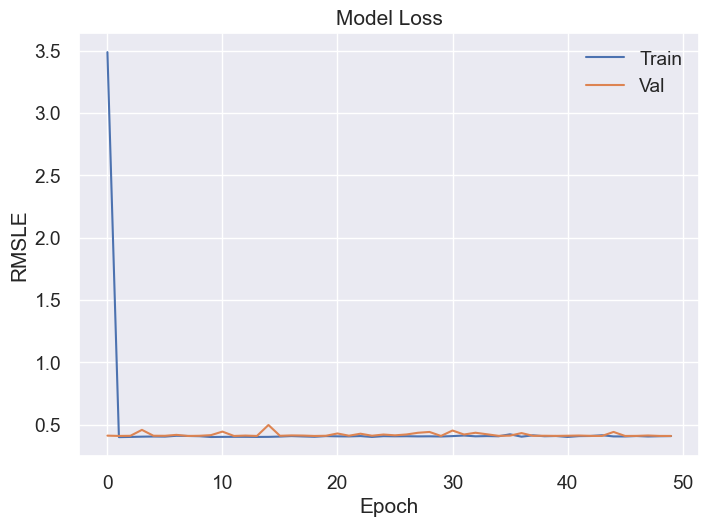

In [38]:
# Evaluate the LSTM model performance
def plot_history(history):
    plt.plot(np.sqrt(history.history['loss']))
    plt.plot(np.sqrt(history.history['val_loss']))
    plt.title('Model Loss')
    plt.ylabel('RMSLE')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='best')
    plt.show()

plot_history(history1)

In [39]:
# Preprocess the test dataset
preproc_Xtest = add_features(test)
preproc_Xtest = preprocessor.transform(test)

# Use the LSTM model to predict test dataset
results_LSTM = LSTM_model.predict(preproc_Xtest)

# Submission
LSTM_submission = pd.DataFrame(test_id,columns=['Id'])
LSTM_submission['SalePrice'] = pd.DataFrame(np.exp(results_LSTM))
LSTM_submission.to_csv(r'submission/LSTM_submission.csv', index=False, header=True)
LSTM_submission

# Kaggle public score: -

46/46 [==============================] - 4s 76ms/step


,Id,SalePrice
0,1461,165423.000000
1,1462,165423.000000
2,1463,165423.000000
3,1464,165423.000000
4,1465,165423.000000
...,...,...
1454,2915,165421.421875
1455,2916,165421.421875
1456,2917,165421.421875
1457,2918,165421.421875
